In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pydicom
from skimage.transform import radon, iradon

In [5]:
def add_poisson_noise(sinogram, scale=1e3):
    """
    Add Poisson noise to a sinogram image.

    :param sinogram: 2D NumPy array representing the sinogram (non-negative).
    :param scale: A scaling factor to simulate photon counts. 
                  Larger scale -> higher counts -> relatively lower noise.
    :return: 2D NumPy array (float) with added Poisson noise.
    """
    # Ensure there are no negative values (Poisson noise requires non-negative input)
    sinogram_clipped = np.clip(sinogram, 0, None)
    
    # Scale up the intensity values to approximate "photon counts"
    sinogram_scaled = sinogram_clipped * scale
    
    # Generate Poisson noise (random photon counts)
    sinogram_noisy_scaled = np.random.poisson(sinogram_scaled).astype(np.float32)
    
    # Scale back down to the original magnitude
    sinogram_noisy = sinogram_noisy_scaled / scale
    
    return sinogram_noisy

Iteration 1/50 complete
Iteration 2/50 complete
Iteration 3/50 complete
Iteration 4/50 complete
Iteration 5/50 complete
Iteration 6/50 complete
Iteration 7/50 complete
Iteration 8/50 complete
Iteration 9/50 complete
Iteration 10/50 complete
Iteration 11/50 complete
Iteration 12/50 complete
Iteration 13/50 complete
Iteration 14/50 complete
Iteration 15/50 complete
Iteration 16/50 complete
Iteration 17/50 complete
Iteration 18/50 complete
Iteration 19/50 complete
Iteration 20/50 complete
Iteration 21/50 complete
Iteration 22/50 complete
Iteration 23/50 complete
Iteration 24/50 complete
Iteration 25/50 complete
Iteration 26/50 complete
Iteration 27/50 complete
Iteration 28/50 complete
Iteration 29/50 complete
Iteration 30/50 complete
Iteration 31/50 complete
Iteration 32/50 complete
Iteration 33/50 complete
Iteration 34/50 complete
Iteration 35/50 complete
Iteration 36/50 complete
Iteration 37/50 complete
Iteration 38/50 complete
Iteration 39/50 complete
Iteration 40/50 complete
Iteration

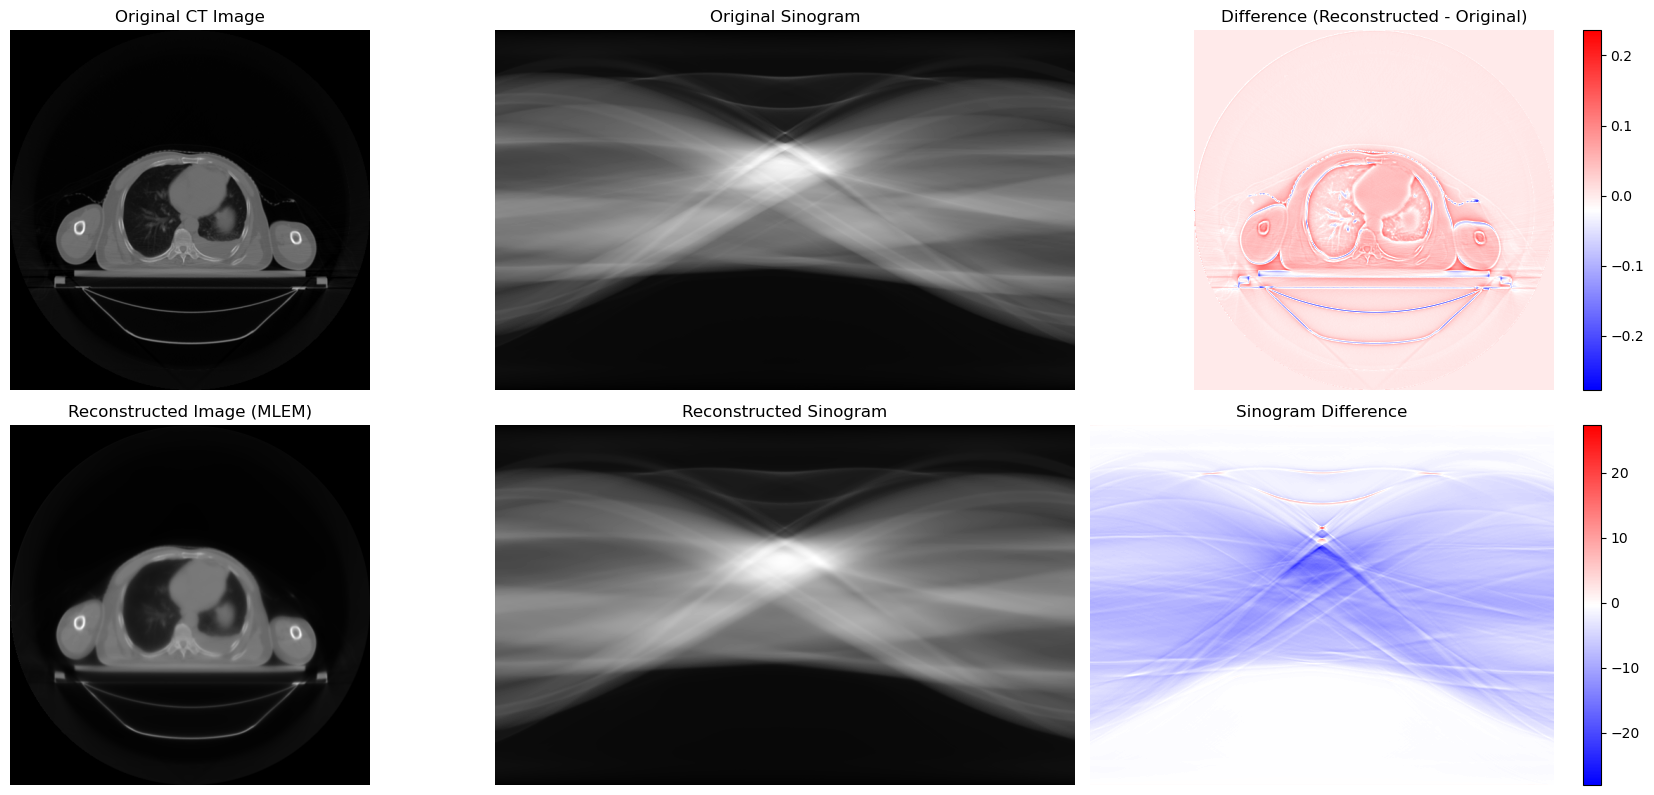

In [4]:
# Define the MLEM reconstruction function
def mlem_reconstruction(ct_filepath, num_iterations=20):
    """
    Perform MLEM reconstruction on a DICOM CT image.

    Parameters:
    - ct_filepath: Path to the DICOM CT file.
    - num_iterations: Number of iterations for MLEM algorithm.

    Returns:
    - reconstructed_image: The reconstructed image after MLEM.
    - original_image: The original CT image.
    - sinograms: A dictionary containing sinograms for visualization.
    """
    # 1. Load the DICOM CT image
    dicom_data = pydicom.dcmread(ct_filepath)
    original_image = dicom_data.pixel_array.astype(np.float32)
    original_image = original_image / np.max(original_image)  # Normalize the image

    # 2. Create the sinogram (Radon Transform)
    theta = np.linspace(0., 180., max(original_image.shape), endpoint=False)
    original_sinogram = radon(original_image, theta=theta, circle=True)
    original_sinogram = add_poisson_noise(original_sinogram)

    # 3. Initialize variables for MLEM
    detector_bins, num_angles = original_sinogram.shape
    reconstructed_image = np.ones((detector_bins, detector_bins), dtype=np.float32)  # Initial guess

    # System matrix approximation (forward and backward projectors using Radon and iradon)
    def forward_projection(image):
        return radon(image, theta=theta, circle=True)

    def backward_projection(sinogram):
        return iradon(sinogram, theta=theta, circle=True, filter_name=None)  # No filtering

    # 4. MLEM iterative reconstruction
    for iteration in range(num_iterations):
        # Forward project the current estimate
        estimated_sinogram = forward_projection(reconstructed_image)

        # Compute the ratio between the actual sinogram and the estimated sinogram
        ratio = original_sinogram / (estimated_sinogram + 1e-8)  # Avoid division by zero

        # Backproject the ratio to update the image
        update_factor = backward_projection(ratio)
        reconstructed_image *= update_factor

        # Normalize to prevent overflow
        reconstructed_image /= np.max(reconstructed_image)

        print(f"Iteration {iteration + 1}/{num_iterations} complete")

    # 5. Compute reconstructed sinogram and differences
    reconstructed_sinogram = forward_projection(reconstructed_image)
    sinogram_difference = original_sinogram - reconstructed_sinogram

    sinograms = {
        "original_sinogram": original_sinogram,
        "reconstructed_sinogram": reconstructed_sinogram,
        "sinogram_difference": sinogram_difference
    }

    return reconstructed_image, original_image, sinograms

# Example usage
ct_filepath = r"D:\WCH_TPS\patient\ProtonPlan\Lung\CT1.2.752.243.1.1.20191027213600427.5400.13601.dcm"  # Replace with your DICOM file path
reconstructed_image, original_image, sinograms = mlem_reconstruction(ct_filepath, num_iterations=50)

# Visualize results
plt.figure(figsize=(18, 12))

# Original image
plt.subplot(3, 3, 1)
plt.imshow(original_image, cmap='gray')
plt.title('Original CT Image')
plt.axis('off')

# Original sinogram
plt.subplot(3, 3, 2)
plt.imshow(sinograms["original_sinogram"], cmap='gray', aspect='auto')
plt.title('Original Sinogram')
plt.axis('off')

# Difference between original and reconstructed images
difference_image = reconstructed_image - original_image
plt.subplot(3, 3, 3)
plt.imshow(difference_image, cmap='bwr')
plt.title('Difference (Reconstructed - Original)')
plt.colorbar()
plt.axis('off')

# Reconstructed image
plt.subplot(3, 3, 4)
plt.imshow(reconstructed_image, cmap='gray')
plt.title('Reconstructed Image (MLEM)')
plt.axis('off')

# Reconstructed sinogram
plt.subplot(3, 3, 5)
plt.imshow(sinograms["reconstructed_sinogram"], cmap='gray', aspect='auto')
plt.title('Reconstructed Sinogram')
plt.axis('off')

# Difference between sinograms
plt.subplot(3, 3, 6)
plt.imshow(sinograms["sinogram_difference"], cmap='bwr', aspect='auto')
plt.title('Sinogram Difference')
plt.colorbar()
plt.axis('off')

plt.tight_layout()
plt.show()

Iteration 1/50 complete
Iteration 2/50 complete
Iteration 3/50 complete
Iteration 4/50 complete
Iteration 5/50 complete
Iteration 6/50 complete
Iteration 7/50 complete
Iteration 8/50 complete
Iteration 9/50 complete
Iteration 10/50 complete
Iteration 11/50 complete
Iteration 12/50 complete
Iteration 13/50 complete
Iteration 14/50 complete
Iteration 15/50 complete
Iteration 16/50 complete
Iteration 17/50 complete
Iteration 18/50 complete
Iteration 19/50 complete
Iteration 20/50 complete
Iteration 21/50 complete
Iteration 22/50 complete
Iteration 23/50 complete
Iteration 24/50 complete
Iteration 25/50 complete
Iteration 26/50 complete
Iteration 27/50 complete
Iteration 28/50 complete
Iteration 29/50 complete
Iteration 30/50 complete
Iteration 31/50 complete
Iteration 32/50 complete
Iteration 33/50 complete
Iteration 34/50 complete
Iteration 35/50 complete
Iteration 36/50 complete
Iteration 37/50 complete
Iteration 38/50 complete
Iteration 39/50 complete
Iteration 40/50 complete
Iteration

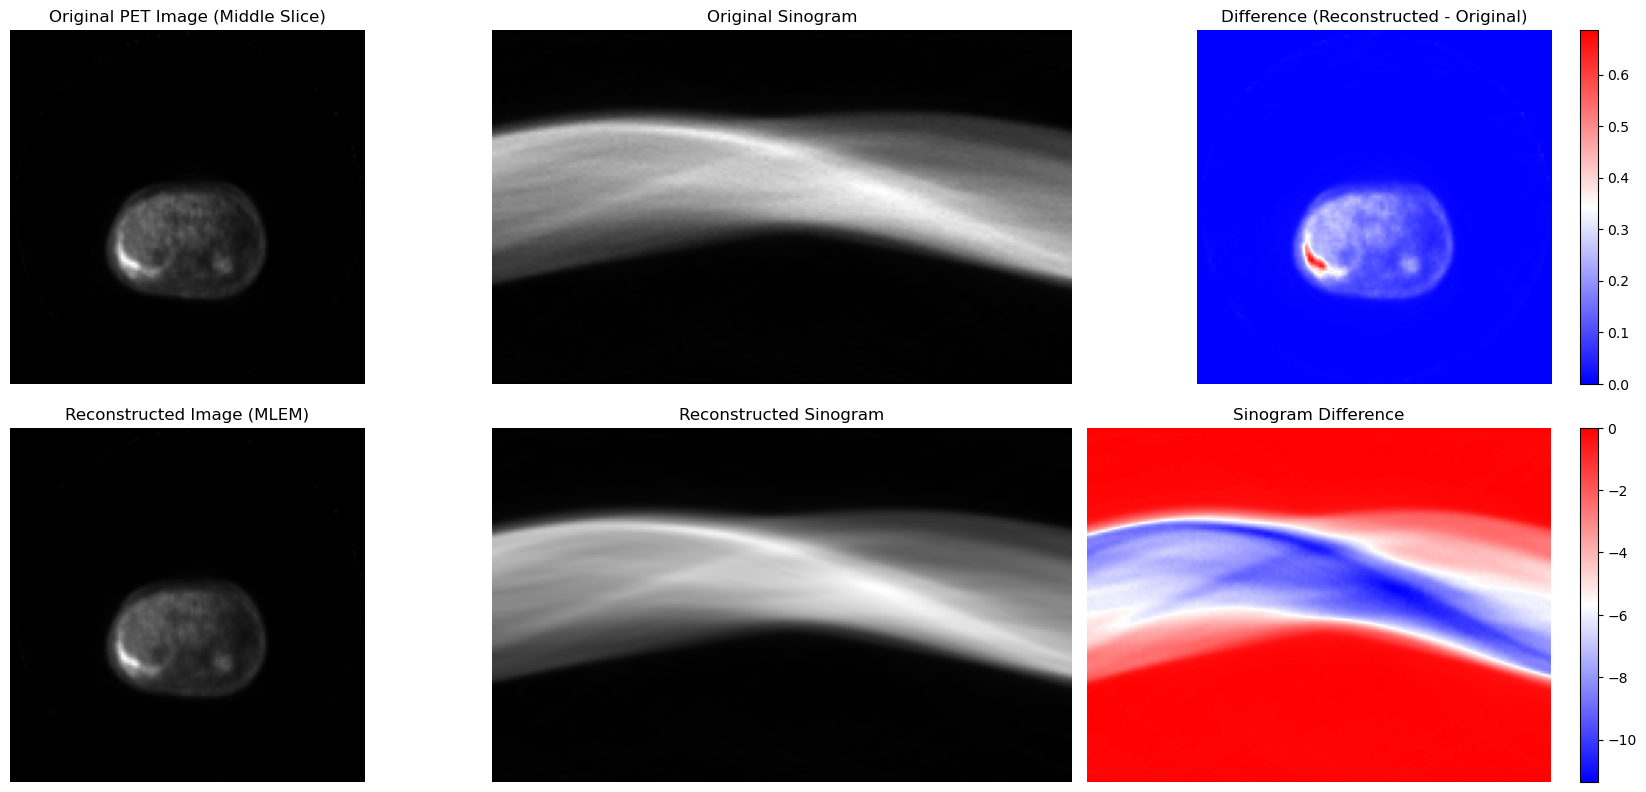

In [6]:
# Define the MLEM reconstruction function
def mlem_reconstruction_pet(pet_folder_path, num_iterations=20):
    """
    Perform MLEM reconstruction on a PET image from a folder of DICOM files.

    Parameters:
    - pet_folder_path: Path to the folder containing PET DICOM files.
    - num_iterations: Number of iterations for MLEM algorithm.

    Returns:
    - reconstructed_image: The reconstructed image after MLEM.
    - original_image: The original PET image (middle slice).
    - sinograms: A dictionary containing sinograms for visualization.
    """
    # 1. Load all DICOM files from the folder and sort by Instance Number
    dicom_files = [os.path.join(pet_folder_path, f) for f in os.listdir(pet_folder_path) if f.endswith('.dcm')]
    dicom_files.sort(key=lambda f: int(pydicom.dcmread(f).InstanceNumber))

    # Load the pixel data into a 3D array
    pet_slices = [pydicom.dcmread(f).pixel_array.astype(np.float32) for f in dicom_files]
    pet_array = np.stack(pet_slices, axis=0)
    pet_array = pet_array / np.max(pet_array)  # Normalize the 3D array

    # Select the middle slice
    middle_slice_idx = pet_array.shape[0] // 2
    original_image = pet_array[middle_slice_idx, :, :]

    # 2. Create the sinogram (Radon Transform)
    theta = np.linspace(0., 180., max(original_image.shape), endpoint=False)
    original_sinogram = radon(original_image, theta=theta, circle=True)
    original_sinogram = add_poisson_noise(original_sinogram)

    # 3. Initialize variables for MLEM
    detector_bins, num_angles = original_sinogram.shape
    reconstructed_image = np.ones((detector_bins, detector_bins), dtype=np.float32)  # Initial guess

    # System matrix approximation (forward and backward projectors using Radon and iradon)
    def forward_projection(image):
        return radon(image, theta=theta, circle=True)

    def backward_projection(sinogram):
        return iradon(sinogram, theta=theta, circle=True, filter_name=None)  # No filtering

    # 4. MLEM iterative reconstruction
    for iteration in range(num_iterations):
        # Forward project the current estimate
        estimated_sinogram = forward_projection(reconstructed_image)

        # Compute the ratio between the actual sinogram and the estimated sinogram
        ratio = original_sinogram / (estimated_sinogram + 1e-8)  # Avoid division by zero

        # Backproject the ratio to update the image
        update_factor = backward_projection(ratio)
        reconstructed_image *= update_factor

        # Normalize to prevent overflow
        reconstructed_image /= np.max(reconstructed_image)

        print(f"Iteration {iteration + 1}/{num_iterations} complete")

    # 5. Compute reconstructed sinogram and differences
    reconstructed_sinogram = forward_projection(reconstructed_image)
    sinogram_difference = original_sinogram - reconstructed_sinogram

    sinograms = {
        "original_sinogram": original_sinogram,
        "reconstructed_sinogram": reconstructed_sinogram,
        "sinogram_difference": sinogram_difference
    }

    return reconstructed_image, original_image, sinograms

# Example usage
pet_folder_path = r"D:\\NIH\\PET-CT\\acrin_nsclc_fdg_pet\\ACRIN-NSCLC-FDG-PET-001\\1.3.6.1.4.1.14519.5.2.1.7009.2403.156046015078185438233607422806\\PT_1.3.6.1.4.1.14519.5.2.1.7009.2403.121694709831221676480030303736"  # Replace with your PET folder path
reconstructed_image, original_image, sinograms = mlem_reconstruction_pet(pet_folder_path, num_iterations=50)

# Visualize results
plt.figure(figsize=(18, 12))

# Original image
plt.subplot(3, 3, 1)
plt.imshow(original_image, cmap='gray')
plt.title('Original PET Image (Middle Slice)')
plt.axis('off')

# Original sinogram
plt.subplot(3, 3, 2)
plt.imshow(sinograms["original_sinogram"], cmap='gray', aspect='auto')
plt.title('Original Sinogram')
plt.axis('off')

# Difference between original and reconstructed images
difference_image = reconstructed_image - original_image
plt.subplot(3, 3, 3)
plt.imshow(difference_image, cmap='bwr')
plt.title('Difference (Reconstructed - Original)')
plt.colorbar()
plt.axis('off')

# Reconstructed image
plt.subplot(3, 3, 4)
plt.imshow(reconstructed_image, cmap='gray')
plt.title('Reconstructed Image (MLEM)')
plt.axis('off')

# Reconstructed sinogram
plt.subplot(3, 3, 5)
plt.imshow(sinograms["reconstructed_sinogram"], cmap='gray', aspect='auto')
plt.title('Reconstructed Sinogram')
plt.axis('off')

# Difference between sinograms
plt.subplot(3, 3, 6)
plt.imshow(sinograms["sinogram_difference"], cmap='bwr', aspect='auto')
plt.title('Sinogram Difference')
plt.colorbar()
plt.axis('off')

plt.tight_layout()
plt.show()